## Yennie Jun Fundamentals of Social Data Science Summative

# Part 1: Examining the Initial Responses of the South Korean and US Governments to COVID-19

## Introduction

The United States and South Korea noted their first case of the COVID-19 virus on January 20, 2020 (Holshue, 2020; Lim, 2020). The two countries responded to the virus in different ways. South Korea responded quickly with a proactive government response, combining rigorous contact tracing, early isolation, and free treatment of positive cases (Lee, 2020). The United States, on the other hand, had a delayed and disorganized response, disbanding the Pandemic Emergency Response Task Force and pushing the responsibility containment and mitigation strategies to individual states (Florida Atlantic University, 2020). 

These different responses led to each country having vastly different experiences with the virus. South Korea flattened the curve within weeks, emerging as a "model to emulate in fighting the pandemic" (You, 2020). On the other hand, the United States has emerged as the epicenter of the virus, boasting an exponentially increasing trajectory of infection cases (Balogun, 2020). To date, the US has experienced over ten million total cases and over 200,000 deaths related to the virus. In August, the US was found to account for 25 percent of COVID-19 cases and deaths in the world while comprising less than 5% of the global population (Florida Atlantic University, 2020). 

In this first section, I examine how fast the South Korean and United States governments responded after the first case of COVID-19 (January 20, 2020), with respect to different government response indicators. A comparison of the South Korean and United States' government responses is especially compelling because the two countries had the same date of first COVID-19 infection, and yet the former is viewed as a "success" story while the latter is viewed more as a "failure." The literature mentions that the South Korean government responded quickly, while the US government's response saw more delays, but I would like to quantify that amount. I inquire as to whether faster government response leads to a more successful COVID-19 containment response, at least in the context of these two countries. 



## Data Analysis

The government response indicators used in this paper are derived from the Oxford COVID-19 Government Response Tracker (Mahdi et al, 2020). More details about the specific indicators are listed in the [GitHub codebook](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md) in the `government response` table (Codebook, 2020). In this paper, I look specifically at the "Containment and closure policies", which are the policies that mention closures of various institutions (i.e. schools, workplaces, public transportation, etc). 

I am interested in the initial response of the two countries' governments to COVID-19, and therefore query for all data from the `government_response` prior to May 1, 2020. I calculate the "days since first infection" by subtracting each "government response" entry from `2020-01-20`.

I extract the government flags that I am interested in, which are all of the flags that begin with `c` in the codebook. An example of this is `c1_school_closing`. Each flag can have multiple levels of restrictions; for example, `1` denotes recommended school closures, whereas `2` denotes required school closures. I calculate the first instance of each stringency level of government response for each of the specified government flags. Using this information, I calculate the number of days it respecitvely took the South Korean and US governments to respond.

In [100]:
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import re
from datetime import datetime

sns.set()
sns.set_style("white")

In [101]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [102]:
# load govtrack table for just the United States and Korea, for the first few months of covid
sql_command = """SELECT * FROM government_response\
    WHERE date < '2020-05-01' and (country = 'United States' or country='South Korea')\
    ORDER by date ASC"""
df_govtrack = pd.read_sql(sql_command, conn)

# convert to datetime
df_govtrack.date = pd.to_datetime(df_govtrack['date'])

# calculate the timedelta of each response to first covid case
df_govtrack['response_since_first_infection'] = df_govtrack['date'] - datetime(2020, 1, 20)

In [478]:
# extract each of the c_xxxx flags mentioned in the government response tracker
gov_flags = [re.search("c\d_[^flag]\w*", col).group() \
             for col in df_govtrack.columns if re.match("c\d_[^flag]\w*", col)]
display(gov_flags)

['c1_school_closing',
 'c2_workplace_closing',
 'c3_cancel_public_events',
 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',
 'c6_stay_at_home_requirements',
 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls']

In [479]:
# Extend gov_flags to include other relevant column indexes that I am interested in looking at
gov_flags.extend(["date", "response_since_first_infection", "country"])

# Get the containment and closure policies on each row for each flag
df_melt = df_govtrack[gov_flags].sort_values(by="date")\
    .melt(id_vars=["date", "response_since_first_infection", "country"])\
    .dropna()

# Display just the last few elements
display(df_melt.tail(3))

,date,response_since_first_infection,country,variable,value
1933,2020-04-29,100 days,United States,c8_international_travel_controls,3
1934,2020-04-30,101 days,South Korea,c8_international_travel_controls,3
1935,2020-04-30,101 days,United States,c8_international_travel_controls,3


In [485]:
# Calculate the "first" instance of for each country for each restriction level
first_restrictions_by_country = df_melt[df_melt.value!=0]\
    .groupby(['variable', 'country', 'value']).first()

# Calculate the "first" instance of all restrictions (regardless of restriction stringency level)
first_restrictions_all_levels = df_melt[df_melt.value!=0].\
    groupby(['variable', 'country']).first().unstack()["response_since_first_infection"]
first_restrictions_all_levels["response_difference"] = \
    first_restrictions_all_levels["United States"] - first_restrictions_all_levels["South Korea"]

# Calculate the average "first instance" across all restrictions
first_restriction_average = df_melt[df_melt.value!=0].groupby(['variable', 'country']).first().unstack()\
    [["response_since_first_infection"]].mean().unstack(0)
first_restriction_average["avg_first_response_in_days"] = \
    first_restriction_average["response_since_first_infection"].dt.days

## Results

In `Figure 1.1` we can see a plot of overall government response of the two countries, captured by the `government_response_index` (an aggregate government response indicator calculated by OxCovid). We can see that South Korea takes government action a lot quicker than the US. In fact, the US does not seem to begin ramping up their response until early- to mid-March. 

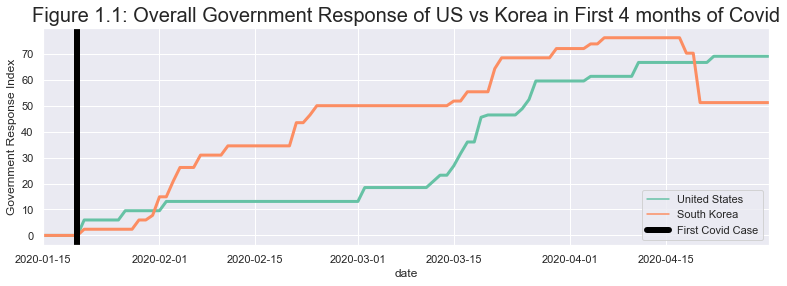

In [521]:
sns.set(rc={'figure.figsize':(13, 4)})

ax = sns.lineplot(data=df_govtrack, x="date", y="government_response_index", hue="country", palette="Set2", lw=3)

# Plot the "first day of contact"
ax.axvline(pd.to_datetime('2020-01-20'), color='black', lw=6, label="First Covid Case")

# Legends, titles, axes
plt.legend()
plt.ylabel('Government Response Index')
plt.xlim(pd.to_datetime('2020-01-15'), pd.to_datetime('2020-04-30'));
plt.title('Figure 1.1: Overall Government Response of US vs Korea in First 4 months of Covid', fontsize=20);

By grouping by government response variable and country, we can see the "first" day that each country's government started implementing a response, and also when the level of that response changed (`Figure 1.2`). We can see that in general, South Korea responded a lot earlier than the US did for nearly every category. Even as the level of restrictions within each category shifted,  South Korea's restriction levels tended to stay higher than the US's restriction levels.

In `Figure 1.3` we can see more of the details of restrictions of each country by restriction level. 

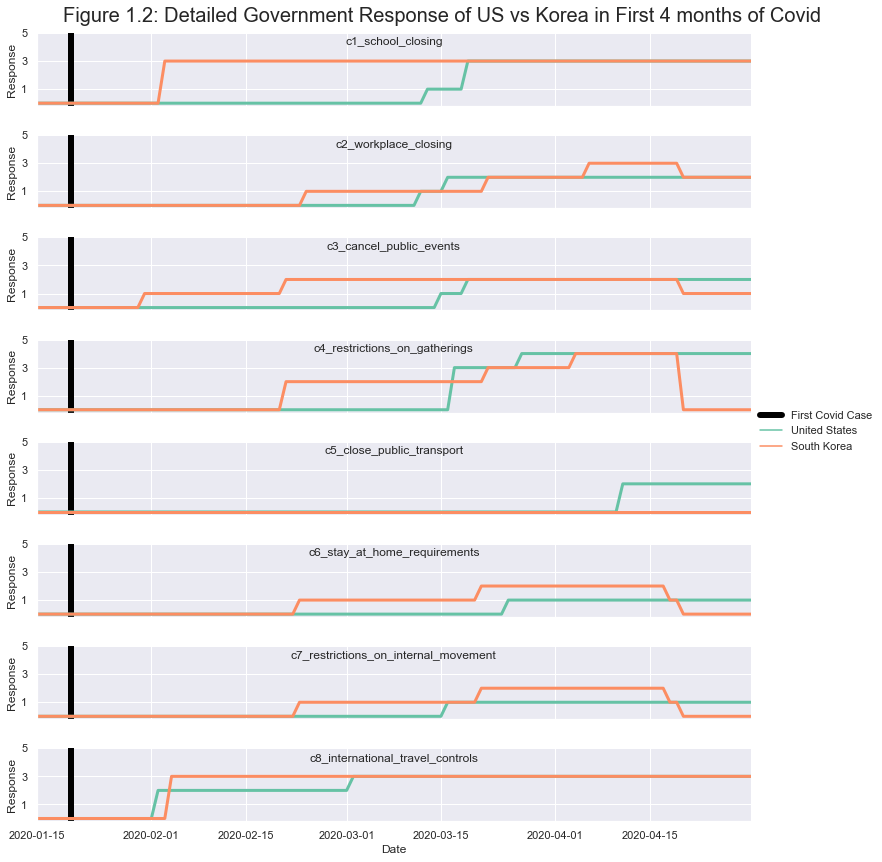

In [685]:
def add_line(**kwargs):
    plt.axvline(pd.to_datetime('2020-01-20'), lw=6, label="First Covid Case", **kwargs);

x_vars = "date"
y_vars = df_melt.variable.unique()

# Seaborn facetgrid for each variable
g = sns.FacetGrid(df_melt, col="variable", height=1.5, col_wrap=1, aspect=7)
# Add a line for the First Covid Case
g.map(add_line, color='black')

# Lineplot for each government response
g.map_dataframe(sns.lineplot, x="date", y="value", hue="country", palette="Set2", lw=3) 
g.set_axis_labels("Date", "Response") # Add axis labels
g.set(xlim=(pd.to_datetime('2020-01-15'), pd.to_datetime('2020-04-30')), yticks=[1,3,5])
g.set_titles(col_template="{col_name}", row_template="{row_name}", y=0.75) # Format subplot titles

# Add legends and titles
g.add_legend()
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Figure 1.2: Detailed Government Response of US vs Korea in First 4 months of Covid', fontsize=20);

<span style="font-size:20px;">Figure 1.3: First Restrictions By Country and Restriction Level</span>

In [691]:
display(first_restrictions_by_country)

date  \
variable                             country       value              
c1_school_closing                    South Korea   3     2020-02-03   
                                     United States 1     2020-03-13   
                                                   3     2020-03-19   
c2_workplace_closing                 South Korea   1     2020-02-24   
                                                   2     2020-03-22   
                                                   3     2020-04-06   
                                     United States 1     2020-03-12   
                                                   2     2020-03-16   
c3_cancel_public_events              South Korea   1     2020-01-31   
                                                   2     2020-02-21   
                                     United States 1     2020-03-15   
                                                   2     2020-03-19   
c4_restrictions_on_gatherings        South Korea   2     2020-02-21   
                                                   3     2020-03-22   
                                                   4     2020-04-04   
                                     United States 3     2020-03-17   
                                                   4     2020-03-27   
c5_close_public_transport            United States 2     2020-04-11   
c6_stay_at_home_requirements         South Korea   1     2020-02-23   
                                                   2     2020-03-21   
                                     United States 1     2020-03-25   
c7_restrictions_on_internal_movement South Korea   1     2020-02-23   
                                                   2     2020-03-21   
                                     United States 1     2020-03-16   
c8_international_travel_controls     South Korea   3     2020-02-04   
                                     United States 2     2020-02-02   
                                                   3     2020-03-02   

                                                         response_since_first_infection  
variable                             country       value                                 
c1_school_closing                    South Korea   3                            14 days  
                                     United States 1                            53 days  
                                                   3                            59 days  
c2_workplace_closing                 South Korea   1                            35 days  
                                                   2                            62 days  
                                                   3                            77 days  
                                     United States 1                            52 days  
                                                   2                            56 days  
c3_cancel_public_events              South Korea   1                            11 days  
                                                   2                            32 days  
                                     United States 1                            55 days  
                                                   2                            59 days  
c4_restrictions_on_gatherings        South Korea   2                            32 days  
                                                   3                            62 days  
                                                   4                            75 days  
                                     United States 3                            57 days  
                                                   4                            67 days  
c5_close_public_transport            United States 2                            82 days  
c6_stay_at_home_requirements         South Korea   1                            34 days  
                                                   2                            61 days  
                       

In `Figure 1.4`, we can see that on average across all of the eight government response variables, the US took twice as long as Korea to respond.

In `Figure 1.5` (also visualized in `Figure 1.6`) we can see each government's response to each of the given government response indicators. For the purpose of this analysis, I have used the "first" response, regardless of its level of severity. 

From these figures, we can determine that although South Korea tended to respond anywhere from 17 to 39 days faster than the United States in terms of nearly all categories of government response, there are two exceptions. First, South Korea shows as having a null value for its response to public transportation. This is because South Korea indeed did not implement public transportation restrictions during the first few months of the COVID-19 pandemic, perhaps due to the fact that mask use was compulsory in public places (Tirachini, 2020).

Second, the only category in which the United States responded faster than South Korea was in "international travel controls." According to the US Department of State, President Trump issued the first COVID-19-related proclamation in January 31, 2020, which blocked entry into the US of foreigners who were present in China (Travel.state.gov., 2020). This proclamation went into effect on February 2.

<span style="font-size:20px;">Figure 1.4: Average First Restriction Response Per Country</span>

In [696]:
display(first_restriction_average[["avg_first_response_in_days"]])

,avg_first_response_in_days
country,
South Korea,25
United States,54


<span style="font-size:20px;">Figure 1.5: First Restrictions By Countries (For All Restriction Levels)</span>


In [693]:
display(first_restrictions_all_levels)

country,South Korea,United States,response_difference
variable,,,
c1_school_closing,14 days,53 days,39 days
c2_workplace_closing,35 days,52 days,17 days
c3_cancel_public_events,11 days,55 days,44 days
c4_restrictions_on_gatherings,32 days,57 days,25 days
c5_close_public_transport,NaT,82 days,NaT
c6_stay_at_home_requirements,34 days,65 days,31 days
c7_restrictions_on_internal_movement,34 days,56 days,22 days
c8_international_travel_controls,15 days,13 days,-2 days


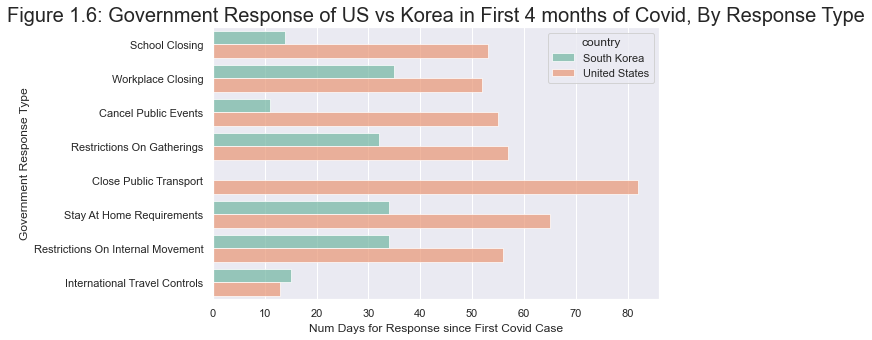

In [694]:
df_bar_data = df_melt[df_melt.value!=0].groupby(['variable', 'country']).first()\
    ["response_since_first_infection"].reset_index()

# Map days (datetime object) to integers
df_bar_data["response_since_first_infection"] = df_bar_data["response_since_first_infection"]\
    .apply(lambda a: a.days)

# Plot barplot
sns.set(rc={'figure.figsize':(8,5)})
g = sns.barplot(data=df_bar_data, y="variable", x="response_since_first_infection", alpha=0.7,
                hue="country", palette="Set2", orient='h', ci=False)

# Format the ticklabels to capitalize each word
g.set_yticklabels([' '.join([a.capitalize() for a in c.split('_')[1:]]) for c in df_melt.variable.unique()])

# Add labels and title
g.set_xlabel('Num Days for Response since First Covid Case')
g.set_ylabel('Government Response Type')
plt.title('Figure 1.6: Government Response of US vs Korea in First 4 months of Covid, By Response Type', fontsize=20);


## Discussion and Limitations

Overall, we can see that in nearly every category of government response, South Korea responded on average 25 days faster than the US did. In some cases (such as in enacting school closure restrictions), South Korea responded up to 39 days faster than the US did. As discussed above, there were only two areas in which this pattern did not hold. The first was in the case of public transportation, in which case South Korea did not enforce any restrictions at all, because they had no need to. In this case, having no response was a better indicator of COVID-19 success than having a stringent response. The second was in the case of international travel restrictions, in which the US responded swiftly and promptly (compared to their response in every other government response indicator).

Despite having the same first case of COVID-19, the difference in responses of the two governments is evident in the analysis that I have provided.

### Factors Not Included in this Analysis
However, before we jump to any conclusions about attributing South Korea's relative success dealing with COVID-19 to faster government response, it is important to take other factors into account. In this analysis, I did not investigate other factors that may have impacted the two governments' responses, such as increase in COVID-19 cases, the public government approval ratings, the propotion of elderly and vulnerable citizens in the population, and the country's history of past pandemics (for example, some scholars theorize that South Korea's experiences with MERS and SARS prompted a more swift response) [cite]. 

In this analysis, I also did not take into account the population size of the respective countries nor of their government structures. The US is a federal republic, meaning that responsibility and power is divided between the central government and the states. Individual states or local governments may have had earlier responses to the pandemic before the central government responded. While state-level and territory-level data is included in the government response table, local-level responses are likely to not be included (Hale et al, 2020)

Conversely, South Korea is a centralized democratic republic with a smaller population than the US. This difference in population size and centrality of the federal government probably had an effect on the various government responses to the pandemic as well.

One other limitation of this analysis comes in the later steps. In quantifying the "first response time", I did not take into account the level of severity of the actions. For example, the chart in `Figure 1.6` does not take into account that South Korea's first response to school closure was at a Level 3, while the US's first response to school closure was at a Level 1. While this was necessary for easy comparison, it is important to acknowledge the nuance lost by ignoring the stringency levels.


### Accuracy of Data
The government responses from the database are labeled as discrete values ranging on a scale from 0 to 3 or 4 (depending on the indicator). Because responses had to be mapped to these values, we lose a lot of nuance of type of response, since we do not know the details of what kind of response the government enacted. We only know the general level of stringency and category of the government response, but we do not know any details beyond that. Indeed, the Blavatnik School of Government (in charge of collecting this data) acknowledges in their working paper the challenges of measuring the diversity of governments' responses to COVID-19 in a systematic way, and of the abstraction of the nuances of these responses in using composite measures (Hale et al, 2020).

It is also important to acknowledge the likelihood of data inaccuracies in the OxCovid database government response indicators. It is inevitable that there will be inaccuracies, inconsistencies, or mistakes. The data in this table were manually collected by a team at Oxford via Internet searches of public news articles and government press releases (Hale et al, 2020). There are bound to be some inadvertent mistakes in the data.


### Future Directions

One future direction can be to include more details of the government responses beyond what is included in the government response table. For example, researchers can scrape the official announcements of the governments at the time of the "first" response and doing simple text analysis (sentiment analysis, topic modeling, or even simple Bag-of-Words) to quantify how these announcements align with the table. Another interesting analysis with this could involve seeing how these sentiments or topics change over time for each country, as more scientific research emerges about COVID-19 and as the severity of the global pandemic increases over time.

Another future direction for researchers could be to investigate the pandemic past the first 3-4 months (i.e. looking past May 1, 2020). Did these patterns of restrictions normalize over time between South Korea and the United States? Do they correlate with severity of COVID-19 cases or deaths?

# Part 2: Analyzing the Relationship between Democracy Index and Restrictive Measures in Response to COVID-19

## Introduction

In the many months since the first outbreak of the COVID-19 pandemic, scholars have pondered the indicators that could be used to predict countries' varying responses and experiences. For example, an article from May suggests that democratic governments (rather than authoritarian governments, such as China's) are the key to success, due to democracy's accountability to the people (Alon et al, 2020). Research from the Carnegie Endowment for International Peace offers a more critical view, arguing that even democratic countries such as South Korea and Italy employed methods bordering on authoritarianism, such as privacy-invasive digital contract tracing apps or criminal penalties for breaking quarantine (Kleinfeld, 2020). 

In this section, I continue the analyses in Part 1 to examine the relationship between government response to COVID-19 and country's level of democracy. I will examine whether the regime type of a government, as described by the Economist's Democracy Index, has an impact on that government's response to enact severe restrictions. What the data show aligns with an article published in August: that democratic and authoritarian governments have their own strengths and weaknesses, and that neither is "unambiguously better at dealing with the threat [of COVID-19]" (Stasavage, 2020). While authoritarian governments' centralized power allows for decisive action, their propensity for secrecy may allow for suppression of information. While democratic governments' transparency allows for greater knowledge of threats, decentralization of power may lead to slower and inefficient response.

I focus specifically on stringent restrictions on internal movements within the country (i.e. Level 2 or above). I would like to investigate whether a country's government (and the democracy level of that government) can explain that country's willingness to impose stringent government controls. Do authoritarian countries tend to respond faster with stringent internal movement controls, and do democratic countries tend to respond slower due to their concerns about individual freedom and privacy?

To measure democracy and regime type, I use the 2019 Democracy Index calculated by the Economist Intelligence Unit (The Economist Intelligence Unit, 2019). While the Democracy Index has its own criticisms and limitations (which will be discussed in the Limitations section below), several studies, including that of Bashar and Tsokos (2019), claim that it is the most comprehensive and collected the best data. The EIU's Democracy Index ingests 60 different indicators to calculate for each country a numeric score representing democracy, as well as a category into a regime type: Full Democracy, Flawed Democracy, Hybrid Regimes, and Authoritarian Regimes.

## Data Analysis

In this analysis, there are three main sources of data that I merge together.

First, I obtain the EIU's Democracy Index by scraping it from the corresponding Wikipedia page. While the EIU's website contains a whitepaper with their data, they do not have a public CSV file or API available on their whitepaper or their website. The most recent version on Wikipedia was sourced on 2020-02-04 from the EIU's report (Democracy Index, 2020). 

Second, I calculate the first case of COVID-19 for each country by loading in the `epidemiology` table from the OxCovid database. I do this by determining the first entry with more than 0 number of cases.

Third, I calculate the stringency for internal movements by extracting the `c7_restrictions_on_internal_movements` flag from the `government_response` table. This specific indicator can take one of the following values: 0 (no measures), 1 (recommended not to travel between regions/cities), 2 (internal movement restrictions in place), and Blank (no data) (Codebook). For this analysis, I focus on restrictions about Level 2, since they are the most stringent, and I wish to examine the most stringent measures by governments to make my connection with authoritarianism.

I merge the data from the Democracy Index, the first case of COVID-19, and internal movement stringency level for each country. In the process, I found that there was missing data for some of the countries. This will be addressed further in the Limitations section. 

In [730]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import re
import datetime as dt
from bs4 import BeautifulSoup

sns.set()
sns.set_style("white")

In [732]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [11]:
# Scraping democracy index from Wikipedia page
response = requests.get("https://en.wikipedia.org/wiki/Democracy_Index")
soup = BeautifulSoup(response.text)

countries, scores, regimetypes, regions = [], [], [], []

for line in soup.find_all("table")[2].find_all("tr")[1:]:
    country = line.find("a").text
    score, regimetype = [a.text for a in line.find_all("b")]
    
    table_items = [t.text for t in line.find_all("td")]
    table_items = [i for i in table_items if 'Score:' not in i]
    
    countries.append(country)
    scores.append(score)
    regimetypes.append(regimetype)
    regions.append(table_items[-1].strip('\n'))

    # Last country in the table
    if country == "North Korea": break

In [12]:
# Convert democracy index lists into dataframe
dem_index = pd.DataFrame([countries, scores, regimetypes, regions]).T
dem_index.columns=["country", "dem_score", "regimetype", "region"]
dem_index.dem_score = dem_index.dem_score.apply(float)
display(dem_index.head())

,country,dem_score,regimetype,region
0,Norway,9.87,Full democracy,Western Europe
1,Iceland,9.58,Full democracy,Western Europe
2,Sweden,9.39,Full democracy,Western Europe
3,New Zealand,9.26,Full democracy,Asia & Australasia
4,Finland,9.25,Full democracy,Western Europe


In [736]:
# Load government tracking data from OX COVID
sql_command_all = """SELECT * FROM government_response\
    WHERE date < '2020-04-01'\
    ORDER by date ASC"""
df_govtrack_all = pd.read_sql(sql_command_all, conn)

# to datetime
df_govtrack_all.date = pd.to_datetime(df_govtrack_all['date'])
df_govtrack_all.government_response_index = df_govtrack_all.government_response_index.apply(float)

In [733]:
# Load epidemiology data from OX COVID
sql_command_epi = """SELECT * FROM epidemiology WHERE date < '2020-04-01' ORDER by date DESC"""
df_epidemiology = pd.read_sql(sql_command_epi, conn)

# to datetime
df_epidemiology.date = pd.to_datetime(df_epidemiology['date'])

In [737]:
# Determine "first case of covid" for each country
first_confirmed = df_epidemiology[df_epidemiology.confirmed>0]\
    .sort_values(by="date")[["country", "date", "confirmed", "gid"]]\
    .groupby("country")\
    .first()

# Extract GIDs from arrays for each row
first_confirmed.gid = first_confirmed.gid.dropna().apply(lambda x: x[0])

# Drop rows with null GIDs. These are continents (ex: Africa, America, etc)
first_confirmed = first_confirmed[~first_confirmed.gid.isna()]

# Some GIDs are have extra numbers after them, get rid of them (ex: POL.3.6_1)
first_confirmed.gid = first_confirmed.gid.apply(lambda x: re.search("(\w\w\w)",x).group(1))

In [738]:
# Selecting only "Restrictions on internal movement" government flag
gov_flags = ['c7_restrictions_on_internal_movement']
gov_flags.extend(["date", "country", "gid"])

# Dataframe with all of the government flags from above, melted
df_melt_all = df_govtrack_all[gov_flags]\
    .sort_values(by="date")\
    .melt(id_vars=["date", "country", "gid"])\
    .dropna()

# Merge in first confirmed date for each country
df_melt_all = df_melt_all.merge(first_confirmed, how="left", on=["gid"])\
    .rename(columns={"date_x": "date", "date_y": "first_confirmed_date"})\
    .drop(columns="confirmed")

# Calculate the number of days for each 
df_melt_all["response_since_first_infection"] = df_melt_all["date"] - df_melt_all["first_confirmed_date"]

In [741]:
display(df_melt_all[df_melt_all.value > 0].sample(5))

,date,country,gid,variable,value,first_confirmed_date,response_since_first_infection
17538,2020-03-27,Gambia,GMB,c7_restrictions_on_internal_movement,1.0,2020-03-17,10 days
17382,2020-03-26,United Arab Emirates,ARE,c7_restrictions_on_internal_movement,2.0,2020-01-27,59 days
15727,2020-03-18,France,FRA,c7_restrictions_on_internal_movement,2.0,2020-01-24,54 days
18278,2020-03-31,San Marino,SMR,c7_restrictions_on_internal_movement,1.0,2020-02-27,33 days
17265,2020-03-26,Mexico,MEX,c7_restrictions_on_internal_movement,1.0,2020-01-14,72 days


In [18]:
# The countries that do not seem to exist in the OxCovid database
df_melt_all[df_melt_all.first_confirmed_date.isna()].country.unique()

array(['Falkland Islands', 'Malawi', 'Vanuatu', 'Lesotho',
       'Solomon Islands', 'Tajikistan', 'Yemen', 'Turkmenistan',
       'Hong Kong', 'Macao', 'South Sudan', 'Pitcairn Islands'],
      dtype=object)

In [806]:
# Only looking at values that are above a 1 in score (i.e. most stringent scores)
# 1=Recommended, 2=Restricted
df_all_countries= df_melt_all[df_melt_all.value>1]\
    .groupby(['variable', 'country'])\
    .first()\
    .unstack()["response_since_first_infection"]\
    .melt()\
    .rename(columns={"value": "response_since_first_infection"})

# Extract just the number of "days" from the time detla
df_all_countries["response_since_first_infection"] = df_all_countries["response_since_first_infection"]\
    .apply(lambda a: a.days)

# Drop the countries with no data about confirmed cases
df_all_countries = df_all_countries[~df_all_countries["response_since_first_infection"].isna()]

# Merge back in the date of the first case of covid
df_all_countries = df_all_countries\
    .merge(first_confirmed.reset_index()[["country", "gid", "date"]], on="country")\
    .rename(columns={"date": "first_case"})

In [807]:
# Merge in democracy score
df_merge = df_all_countries.merge(dem_index, on="country")
display(df_merge.sample(5))

,country,response_since_first_infection,gid,first_case,dem_score,regimetype,region
12,Bosnia and Herzegovina,15.0,BIH,2020-03-05,4.86,Hybrid regime,Eastern Europe
36,Finland,58.0,FIN,2020-01-29,9.25,Full democracy,Western Europe
65,Mexico,76.0,MEX,2020-01-14,6.09,Flawed democracy,Latin America
6,Azerbaijan,19.0,AZE,2020-02-29,2.75,Authoritarian,Eastern Europe
63,Mali,0.0,MLI,2020-03-25,4.92,Hybrid regime,Sub-Saharan Africa


In [808]:
# Convert "first case" date to different time frames for extra analysis
df_merge['first_case_woy'] = df_merge.first_case.dt.isocalendar().week # week of year
df_merge['first_case_biweekly'] = df_merge.first_case_woy//2           # every [two weeks] of year
df_merge['first_case_month'] = df_merge.first_case.dt.month            # month of year
df_merge['first_case_ordinal'] = pd.to_datetime(df_merge['first_case'])\
    .apply(lambda date: date.toordinal())                               # date as ordinal


# A ranking/ordering for regime type in order of authoritarian to democratic
regimetype_order = {"Authoritarian": 0, "Hybrid regime": 1, "Flawed democracy": 2, "Full democracy": 3}
df_merge["regimetype_order"] = df_merge.regimetype.map(regimetype_order)

In [931]:
# Calculate average response time before and after Feb 15 for each regime type

average_response_time_before_feb_15 = df_merge[df_merge.first_case < datetime(2020,2,15)]\
    .groupby(["regimetype_order", "regimetype"])\
    .mean()["response_since_first_infection"]\
    .to_frame()\
    .rename(columns={"response_since_first_infection": "avg_response_days"})\
    .apply(lambda x: round(x, 2))\
    .reset_index()\
    .drop(columns=["regimetype_order"])

average_response_time_after_feb_15 = df_merge[df_merge.first_case > datetime(2020,2,15)]\
    .groupby(["regimetype_order", "regimetype"])\
    .mean()["response_since_first_infection"]\
    .to_frame()\
    .rename(columns={"response_since_first_infection": "avg_response_days"})\
    .apply(lambda x: round(x, 2))\
    .reset_index()\
    .drop(columns=["regimetype_order"])

## Results

We can see that some countries, like Mongolia, responded with strict internal movement restrictions **18 days** before their first Covid case (`Figure 2.1 (a)`). On the other end of the spectrum, Mexico responded with Level 2 stringent restrictions on internal movement 76 days after their first case (`Figure 2.1 (b)`). One pattern to note is that countries that responded faster with stringent measures of internal movement tended to have a later date for first COVID-19 case (mid- to late-March), whereas the countries that responded slower tended to have an earlier date for first COVID-19 case (mid- to late-January).

<span style="font-size:20px;">Figure 2.1 (a): Countries with fastest responses</span>


In [836]:
display(df_merge[["country", "response_since_first_infection", "first_case", "dem_score", "regimetype"]]\
        .sort_values(by='response_since_first_infection').head(10))

,country,response_since_first_infection,first_case,dem_score,regimetype
67,Mongolia,-18.0,2020-03-10,6.50,Flawed democracy
42,Guatemala,-8.0,2020-03-14,5.26,Hybrid regime
59,Libya,-2.0,2020-03-24,2.02,Authoritarian
32,El Salvador,-1.0,2020-03-19,6.15,Flawed democracy
105,Venezuela,-1.0,2020-03-14,2.88,Authoritarian
44,Haiti,-1.0,2020-03-20,4.57,Hybrid regime
17,Cape Verde,0.0,2020-03-20,7.78,Flawed democracy
35,Fiji,0.0,2020-03-19,5.85,Hybrid regime
63,Mali,0.0,2020-03-25,4.92,Hybrid regime
61,Madagascar,1.0,2020-03-20,5.64,Hybrid regime


<span style="font-size:20px;">Figure 2.1 (b): Countries with slowest responses</span>


In [838]:
display(df_merge[["country", "response_since_first_infection", "first_case", "dem_score", "regimetype"]]\
        .sort_values(by='response_since_first_infection').tail(10))

,country,response_since_first_infection,first_case,dem_score,regimetype
37,France,53.0,2020-01-24,8.12,Full democracy
16,Canada,54.0,2020-01-26,9.22,Full democracy
4,Australia,54.0,2020-01-25,9.09,Full democracy
102,United Arab Emirates,56.0,2020-01-27,2.76,Authoritarian
36,Finland,58.0,2020-01-29,9.25,Full democracy
70,Nepal,59.0,2020-01-23,5.28,Hybrid regime
92,South Korea,62.0,2020-01-19,8.00,Flawed democracy
103,United Kingdom,72.0,2020-01-11,8.52,Full democracy
96,Thailand,74.0,2020-01-12,6.32,Flawed democracy
65,Mexico,76.0,2020-01-14,6.09,Flawed democracy


If we group solely by regime type, the data in `Figure 2.2` seem to be telling us something interesting. The more authoritarian the regime type of the government, the faster they tend to respond with stringent measures for internal movement. This seems to confirm our knowledge from the literature - authoritarian governments are likely to enact more restrictive measures, whereas democratic governments are likely to be more cognizant about citizens' privacy and freedom. But is it accurate to conclude that authoritarian governments tend to enact restrictive movement measures faster than democratic governments? 

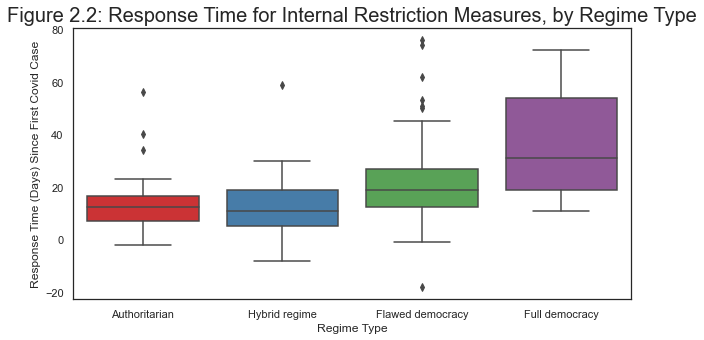

In [789]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.boxplot(ax=ax, x="regimetype", y="response_since_first_infection", 
                order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge, palette="Set1")
plt.xlabel('Regime Type')
plt.ylabel('Response Time (Days) Since First Covid Case')
plt.title('Figure 2.2: Response Time for Internal Restriction Measures, by Regime Type', fontsize=20);

`Figure 2.3` confirms the intuition from `Figure 2.1`, that countries with faster response times tended to have later first cases of COVID-19. At least by first glance, democracy index does not seem to have much of an impact on determining a country's response to COVID-19. Perhaps the date of the first COVID-19 infection is more influential in determining a government's enactment of stringent internal restrictions, rather than their democracy score or regime type. 

In general, countries that experienced their first COVID-19 case before February 15, 2020 tended to respond faster than the countries with earlier first COVID-19 cases. There are a few outliers, and I have marked the names of the countries whose first case was before Feb 15, but they responded under 30 days. I have also marked the names of the countries that responded more than 1 day before their first case of COVID-19 infection.

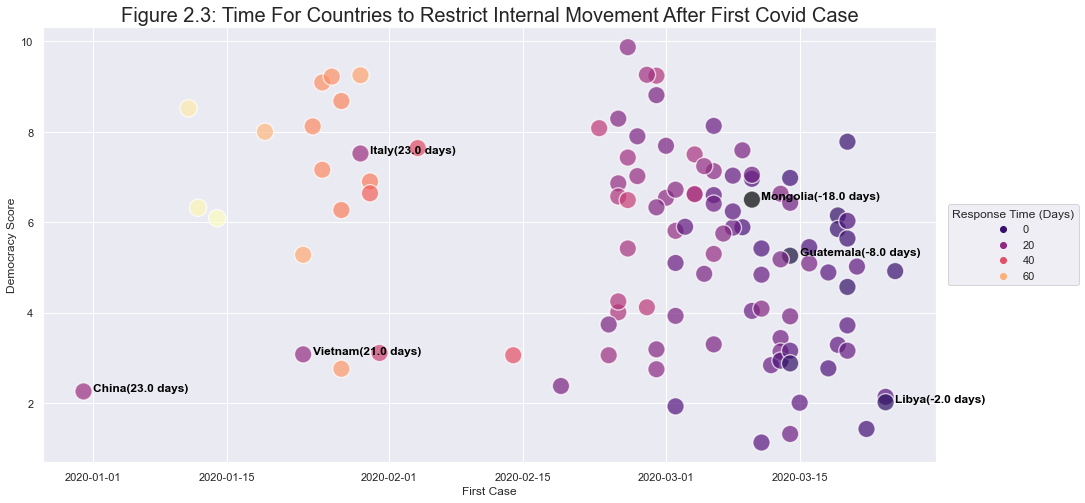

In [834]:
sns.set(rc={'figure.figsize':(16, 8)})

g = sns.scatterplot(data=df_merge, x="first_case", y="dem_score",
                hue="response_since_first_infection", s=300, alpha=.7, palette="magma")
plt.legend(bbox_to_anchor=(1.16, 0.5), loc='center right', borderaxespad=0.)

plt.xlabel('First Case')
plt.ylabel('Democracy Score')

# Add country labels for those who responded fast before February 15 
#   or responded more than 1 day before their first case of covid
for line in range(0,df_merge.shape[0]):
    label_country = (df_merge.first_case[line] < datetime(2020,2,15) \
                 and df_merge.response_since_first_infection[line] < 30) \
                or df_merge.response_since_first_infection[line] < -1
    if label_country:
        g.text(x=df_merge.first_case[line]+pd.DateOffset(hours=24), 
               y=df_merge.dem_score[line], 
               s=f"{df_merge.country[line]}({df_merge.response_since_first_infection[line]} days)", 
               horizontalalignment='left', 
               size='medium', 
               color='black', 
               weight='semibold')

leg = g.axes.get_legend()
leg.set_title("Response Time (Days)")
plt.title("Figure 2.3: Time For Countries to Restrict Internal Movement After First Covid Case", fontsize=20);


I combine both the influences of regime type (as a broader proxy of democracy index), the date of the first COVID-19 case, and the number of days it took to enact strict restrictions of internal movements. In  `Figure 2.4 (a)`, we can see the government response time, separated by regime type, with the date of the first COVID-19 case aggregated by month. `Figure 2.4 (b)` shows the same data, but aggregated at a biweekly scale (every two weeks).

We can see that for the countries with earlier first COVID-19 cases (i.e. before mid-February), authoritarian countries tended to respond a lot faster. We can also see that for the countries with later first COVID-19 dates (i.e. after mid-February), the regime type tended to have less of an influence in response time, as the data points were clustered more closer together.

In `Figure 2.4 (c)`, we see the same information aggregated at a weekly scale (i.e. week of year), this time as a strip plot, and we can see that after week 8, the response time tends to be a lot more clustered and less variable.

Overall, it seems that the date of the first case of COVID-19 is very influential upon the number of days it took for the government to enact restrictions, although the regime type of that government is not negligible. One way to interpret this can be that, for countries with earlier first cases of COVID-19, the regime type tended to influence stringency of measures. For countries with later first cases of COVId-19, the regime type had less of an influence on stringency measures.

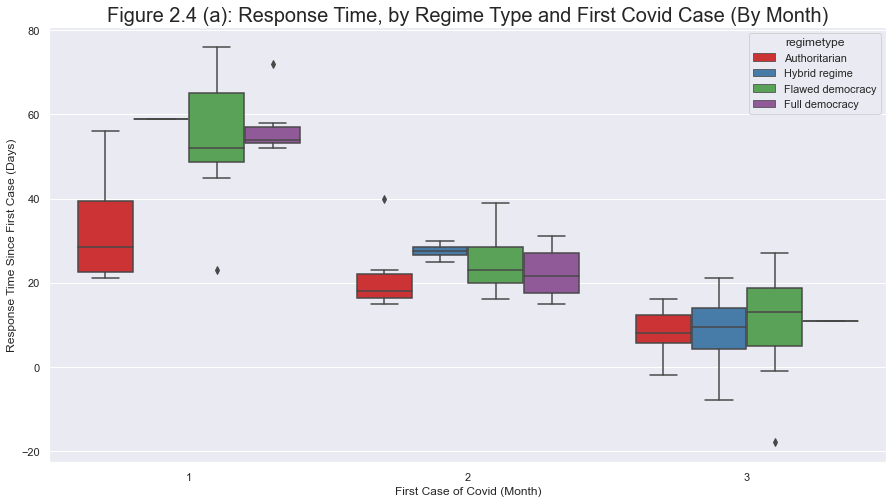

In [809]:
df_merge_months = df_merge.copy()

# Special case: China's first case was december 31, 2019. we will interpret this as january
df_merge_months.loc[df_merge_months.country=="China", "first_case_month"] = 1

a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax, x="first_case_month", y="response_since_first_infection", hue="regimetype", 
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge_months, palette="Set1")
plt.xlabel('First Case of Covid (Month)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Figure 2.4 (a): Response Time, by Regime Type and First Covid Case (By Month)', fontsize=20);

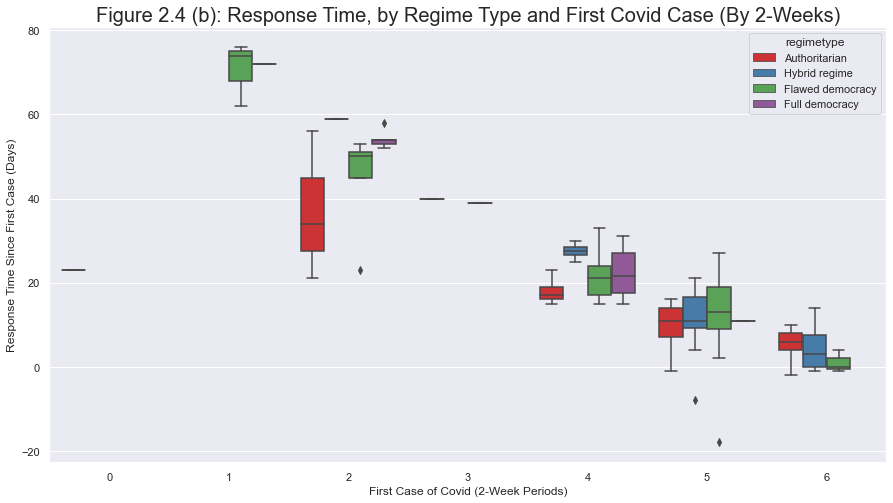

In [812]:
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(ax=ax, x="first_case_biweekly", y="response_since_first_infection", hue="regimetype", 
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge, palette="Set1")
plt.xlabel('First Case of Covid (2-Week Periods)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Figure 2.4 (b): Response Time, by Regime Type and First Covid Case (By 2-Weeks)', fontsize=20);

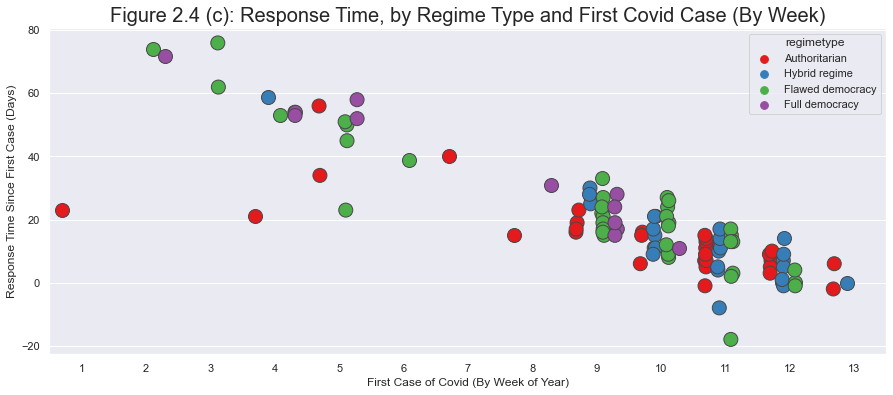

In [813]:
sns.set(rc={'figure.figsize':(15, 6)})

sns.stripplot(x="first_case_woy", y="response_since_first_infection", hue="regimetype", dodge=True, 
                zorder=1, size=14, linewidth=1,
                hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                data=df_merge_months, palette="Set1")
plt.xlabel('First Case of Covid (By Week of Year)')
plt.ylabel('Response Time Since First Case (Days)')
plt.title('Figure 2.4 (c): Response Time, by Regime Type and First Covid Case (By Week)', fontsize=20);

Finally, in `Figure 2.5 (a)`, we can view a visual of a government's response to impose internal movement restrictions for countries that experienced their first case of COVID-19 before February 15, 2020. I chose February 15 as the cutoff, since we saw in `Figure 2.3` and in `Figure 2.4(c)` that around that halfway point is when behavior of clustering seemed to shift. 

In `Figure 2.5 (a)` we can see that authoritarian governments do tend to have shorter arrows (denoting shorter response time) verses other government types. We can also see in `Figure 2.6` that same information quantified as averages for each regime type, for countries with first cases before February 15 in and with first cases after February 15. On average, authoritarian countries responded a lot faster for the former. However, for countries with later first COVID-19 cases, there is no significant difference among the different regime types.

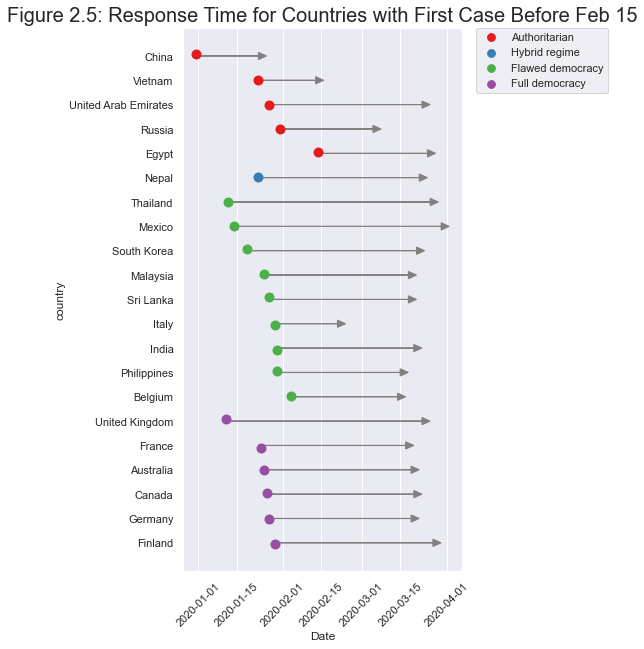

In [945]:
# plotting inspired by https://nikkimarinsek.com/blog/how-to-make-an-arrow-plot
ax = plt.figure(figsize=(5,10))

data = df_merge[df_merge.first_case < datetime(2020,2,15)].sort_values(by=["regimetype_order", "first_case"]).reset_index()

#add start points
ax = sns.stripplot(data=data, 
                   x='first_case', 
                   y='country', 
                   orient='h', 
                   hue='regimetype',
                   hue_order=["Authoritarian", "Hybrid regime", "Flawed democracy", "Full democracy"],
                   size=10,
                   palette='Set1',
                  )
arrow_starts = data['first_case'].values
arrow_lengths = data['response_since_first_infection']

#add arrows to plot
for i, subject in enumerate(data['country']):
    ax.arrow(arrow_starts[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=.3,         #arrow head width
             head_length=3,        #arrow head length
             width=0.01,              #arrow stem width
             fc='gray',             #arrow fill color
             ec='gray')             #arrow edge color

plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Date')
plt.title('Figure 2.5: Response Time for Countries with First Case Before Feb 15', fontsize=20);

In [961]:
def plot_barplot_subplot(df, ax, title_suffix):
    g = sns.barplot(x="regimetype", y="avg_response_days", data=df, ax=ax, palette="Set1")

    for index, row in df.iterrows():
        g.text(row.name,row.avg_response_days, row.avg_response_days, color='black', ha="center")
    
    ax.set_ylim(0,80)
    ax.set_ylabel("Average Response Time (Days)")
    ax.set_xlabel("Regime Type")
    ax.title.set_text(f"Countries with First Case {title_suffix}")

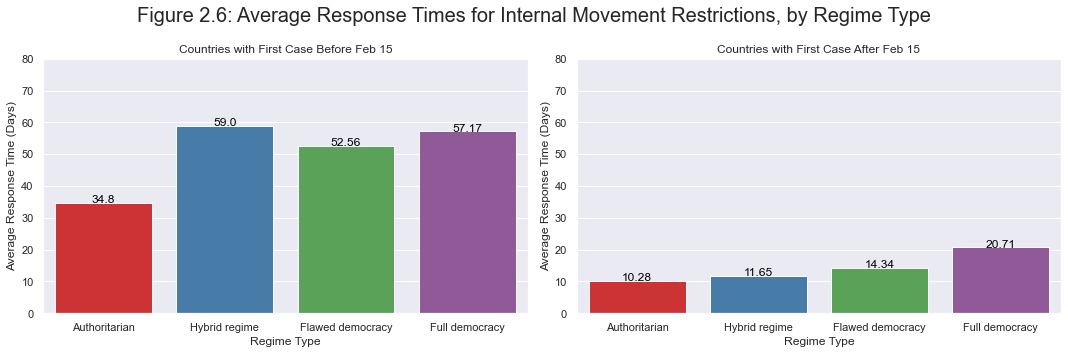

In [962]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plot_barplot_subplot(average_response_time_before_feb_15, axes[0], "Before Feb 15")
plot_barplot_subplot(average_response_time_after_feb_15, axes[1], "After Feb 15")

fig.suptitle("Figure 2.6: Average Response Times for Internal Movement Restrictions, by Regime Type", 
             y=0.98, fontsize=20)
fig.tight_layout()

## Discussion and Limitations

At first glance, it seemed like authoritarian countries responded faster than democratic countries in enacting strict rules about internal movements. Some authoritarian countries responded days (for example, in the case of Mongolia, 18 days) before reporting their first COVID-19 case. 

However, once we divide up the data by the date of the first COVID-19 case, we can see that authoritarian countries tended to have later COVID-19 cases. 

We should recognize that authoritarian countries did tend to respond faster than democratic countries. On the other hand, we should not make broad claims or conclusions that authoritarian countries necessarily lead to faster response, since the date of the first COVID-19 case seemed to have a larger impact on quickness of response. As the date of first COVID-19 became later and later, the effect of regime type seemed to have less of an impact on how quick a government tended to respond with stringent internal movement restrictions. This i a more complex view that aligns with the view that authoritarian nor democratic governments offer different strengths and weaknesses. (Stasavage, 2020).

### Factors Not Included in the Analysis
Similar to Part 1, there are several outstanding factors that I do not include in my analysis that could have been influential. Future researchers could include factors such as country population, COVID-19 severity, and country history with previous pandemics. For example, perhaps the reason South Korea responded slowly to enact stringent movement restrictions is because they had no need to, precisely because their case numbers never rose too high. Other interesting directions to look can include geographic proximity of countries to China, where the initial outbreak of the virus occurred. For example, perhaps one of the reasons Mongolia responded so quickly is due to their sharing a border with China. 

### Validity of Data Sources

It is important to be critical of the data sources used in this analysis. I used the EIU's Democracy Index as a proxy for countries' level of authoritarianism and democracy, but there have been some criticisms of the index. Bashar and Tsokos (2019) suggest that the EIU's Democracy Index may not be very accurate, as it does not take into consideration the interactions and correlations among the collected data. 

There have also been some gaps in the OxCovid database as well. There was no data about case numbers for the following countries: Falkland Islands, Malawi, Vanatu, Lesotho, Solomon Islands, Tajikistan, Yemen, Turkmenistan, Hong Kong, Macao, South Sudan, and Pitcairn Islands. Further, there are issues (mentioned already in Part 1's Limitation section) about losing nuance of severity level and human transcription errors in creating the database.


Lastly, there can be some concerns about the accuracy of the first case of COVID-19 calculated for each country. One study uses statistical methods to show that authoritarian governments are likely to have manipulated the data they published about their COVID-19 numbers (Kapoor et al, 2020). The dates of the first COVID-19 case may be inaccurate and the analysis of this paper misleading, due to the possibility that the data in the database are inaccurate or falsified.

# Works Cited

Alon, I., Farrell, M., & Li, S. (2020). Regime Type and COVID-19 Response. FIIB Business Review, 9, 152 - 160.

Bashar, R., & Tsokos, C. (2019). Statistical Classification of Democracy Index Scores of Countries of the World.

Codebook for the Oxford Covid-19 Government Response Tracker (2020). GitHub Repository. Retrieved November 18, 2020 from https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md.

Balogun, J. A. (2020). Commentary: Lessons from the USA delayed response to the COVID-19 pandemic. African journal of reproductive health, 24(1), 14-21.

Democracy Index. (2020). Democracy Index. Retrieved November 29, 2020, from https://en.wikipedia.org/wiki/Democracy_Index. 

Florida Atlantic University. (2020, August 20). COVID-19: How South Korea prevailed while the United States failed. ScienceDaily. Retrieved November 13, 2020 from www.sciencedaily.com/releases/2020/08/200820102431.htm.

Hale, T., Webster, S., Petherick, A., Phillips, T., & Kira, B. (2020). Oxford COVID-19 Government Response Tracker, Blavatnik School of Government.

Holshue, M.L., DeBolt, C., Lindquist, S., Lofy, K.H., Wiesman, J., Bruce, H., Spitters, C.L., Ericson, K., Wilkerson, S., Tural, A., Díaz, G.T., Cohn, A., Fox, L., Patel, A., Gerber, S., Kim, L., Tong, S., Lu, X., Lindstrom, S., Pallansch, M., Weldon, W., Biggs, H., Uyeki, T.M., & Pillai, S. (2020). First Case of 2019 Novel Coronavirus in the United States. The New England Journal of Medicine, 382, 929 - 936.

Kapoor, M., Malani, A., Ravi, S., & Agrawal, A. (2020). Authoritarian Governments Appear to Manipulate COVID Data. arXiv: General Economics.

Kleinfeld, R. (2020). Do Authoritarian Or Democratic Countries Handle Pandemics Better?. Carnegie Endowment for International Peace. Retrieved November 29, 2020, from https://carnegieendowment.org/2020/03/31/do-authoritarian-or-democratic-countries-handle-pandemics-better-pub-81404.

Lee, D., Heo, K., & Seo, Y. (2020). COVID-19 in South Korea: Lessons for developing countries. World Development, 135, 105057 - 105057.

Lim, J., Jeon, S., Shin, H.Y., Kim, M.J., Seong, Y.M., Lee, W.J., Choe, K.W., Kang, Y.M., Lee, B., & Park, S.J. (2020). Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR. Journal of Korean Medical Science, 35.

Mahdi, A., Blaszczyk, P., Dlotko, P., Salvi, D., Chan, T., Harvey, J., Gurnari, D., Wu, Y., Farhat, A., Hellmer, N., Zarebski, A., Hogan, B., & Tarassenko, L. (2020). OxCOVID19 Database: a multimodal data repository for better understanding the global impact of COVID-19. medRxiv.

Stasavage, D. (2020). Democracy, Autocracy, and Emergency Threats: Lessons for COVID-19 From the Last Thousand Years. International Organization, 1-17. doi:10.1017/S0020818320000338

The Economist Intelligence Unit. (2019). Democracy Index 2019. Retrieved November 13, 2020, from https://www.eiu.com/topic/democracy-index.

Tirachini, A., & Cats, O. (2020). COVID-19 and Public Transportation: Current Assessment, Prospects, and Research Needs. The Journal of Public Transportation, 22, 1.

Travel.state.gov. (2020). Presidential Proclamations On Novel Coronavirus. Retrieved November 29, 2020, from https://travel.state.gov/content/travel/en/News/visas-news/presidential-proclamation-coronavirus.html.

You, J. (2020). Lessons From South Korea’s Covid-19 Policy Response. The American Review of Public Administration, 50, 801 - 808.